<div style="display:inline;"><div style="text-align:left;">University Mohammed VI<br>
Polytechnic (UM6P)<br>
College of computing<br>
</div>
<div style="text-align:right;">
Année: 2023-2024<br>
</div>
</div>

**Student Name**: DOSSEH AMECK GUY-MAX DESIRE 

# <center> Lab 4 - Linear Models for Regression</center>

The [NO2 dataset](https://www.openml.org/d/547) contains 500 measurement of pollution caused by cars. The goal is to predict the concentration of $NO_2$ from data about traffic and atmospheric conditions. The predictive variables include the number of cars per hour, temperature, wind, and time of day.

<div style="text-align:center;">
<img src="https://avatars.mds.yandex.net/i?id=c080f8d71fab2b937ebaaffc74901c7a9dcf3121-10547508-images-thumbs&n=13" width=1000, height=600>
</div>



In [34]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import random
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

import seaborn as sns 

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from print_versions import print_versions
# libraries versions
print_versions(globals())

# python version
import sys
print(sys.version)

numpy==1.24.4
pandas==2.0.3
sklearn==1.3.2
matplotlib==3.7.5
openml==0.14.2
seaborn==0.13.2
3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]


In [35]:
seed = 2024
random.seed(seed)
np.random.seed(seed)

In [36]:
# Download NO2 data. Takes a while the first time.
no2 = oml.datasets.get_dataset(547)
X, y, _, _ = no2.get_data(target=no2.default_target_attribute);
attribute_names = list(X)

C:\Users\duamelo\AppData\Local\Temp\ipykernel_4184\120416378.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  no2 = oml.datasets.get_dataset(547)


## Quick visualization
We can use pandas to quickly visualize the data. If you are new to pandas, take some time to understand the code.

We'll remove the 'day' feature to focus on the non-temporal aspects of this interaction. We are not aiming to predict future levels, and even if we would it would require special treatment (e.g. different train-test splits). There also doesn't seem to be a long term trend in the data, even though there are clear periodic trends in temperature.

C:\Users\duamelo\AppData\Local\Temp\ipykernel_4184\999795560.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  df.plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));


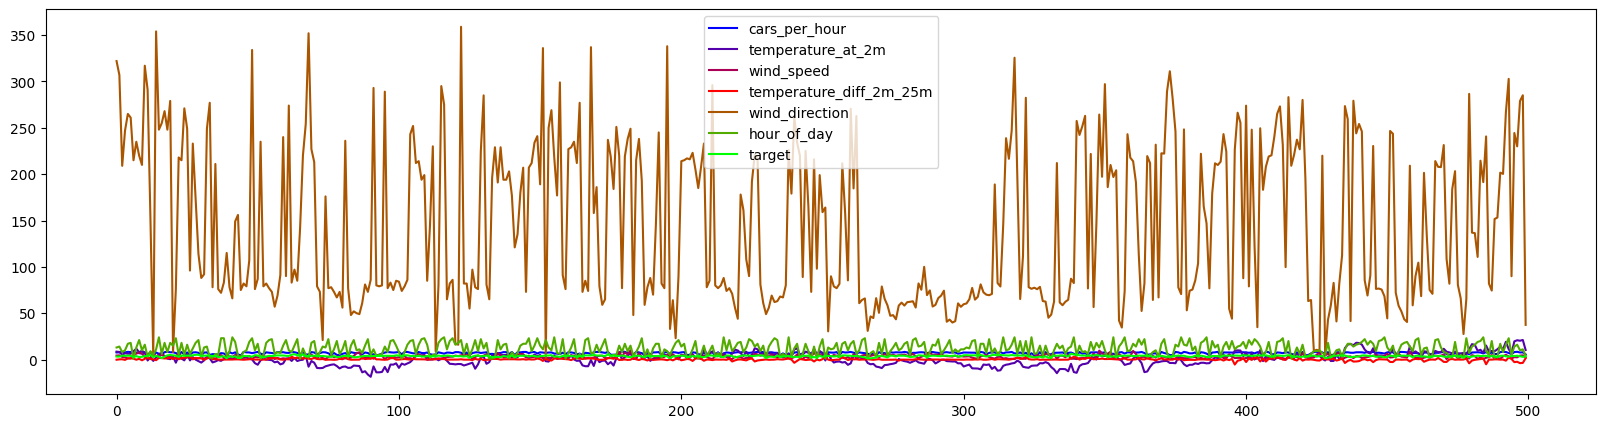

In [37]:
df = pd.DataFrame(X, columns=attribute_names).join(pd.DataFrame(list(y),columns=['target']))
df = df.sort_values(['day','hour_of_day']).drop('day',axis=1)
df.plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));
X = X.drop('day',axis=1)

In [38]:
df.head()

,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,target
42,7.64300,8.5,4.3,-0.2,322.0,13,3.22287
20,7.75061,8.2,4.5,0.2,307.0,14,3.15274
255,8.12415,5.2,2.8,0.3,209.0,8,4.19570
488,7.64108,6.7,2.3,-0.4,247.0,10,3.98155
94,8.31630,6.3,1.2,1.3,265.0,17,4.14155


If we plot the data, ordered by time of measurement, we can see that the wind direction (measured in angular degrees) is scaled very differently from the other features. Let's now zoom in to the other measures:

C:\Users\duamelo\AppData\Local\Temp\ipykernel_4184\2419690043.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));


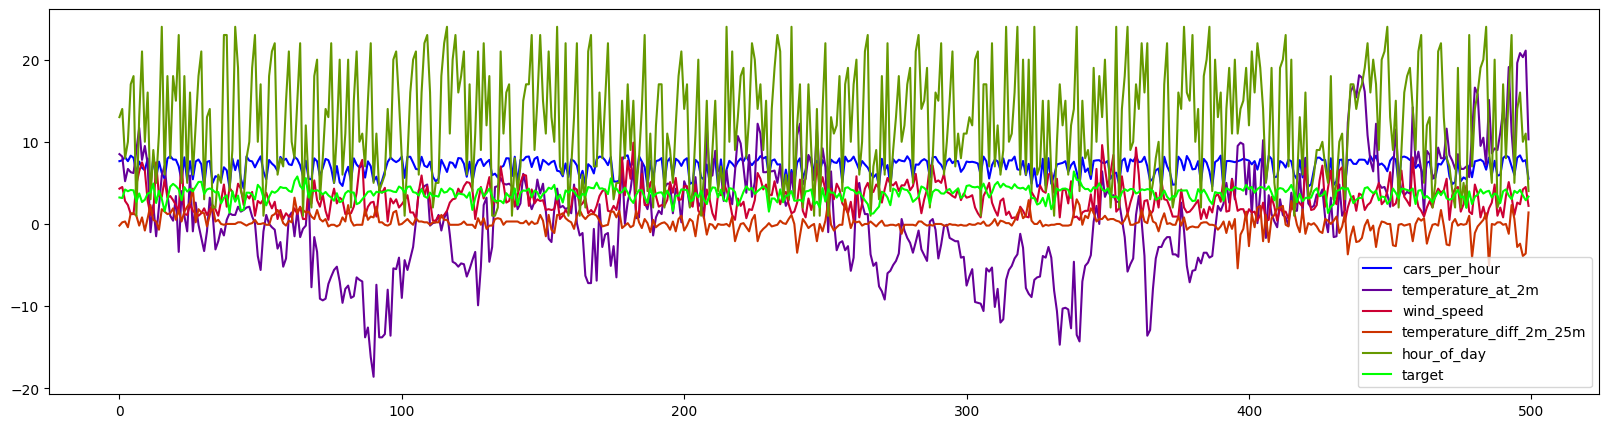

In [39]:
df.drop('wind_direction',axis=1).plot(use_index=False,figsize=(20,5),cmap=cm.get_cmap('brg'));

We can see that the target ($NO_2$ levels) seem to be correlated to the number of cars per hour, which makes sense because cars produce $NO_2$. Other influences (air temperature differences and wind) seem to have a more complex and subtle effect. Let's try to model these using linear regression models.

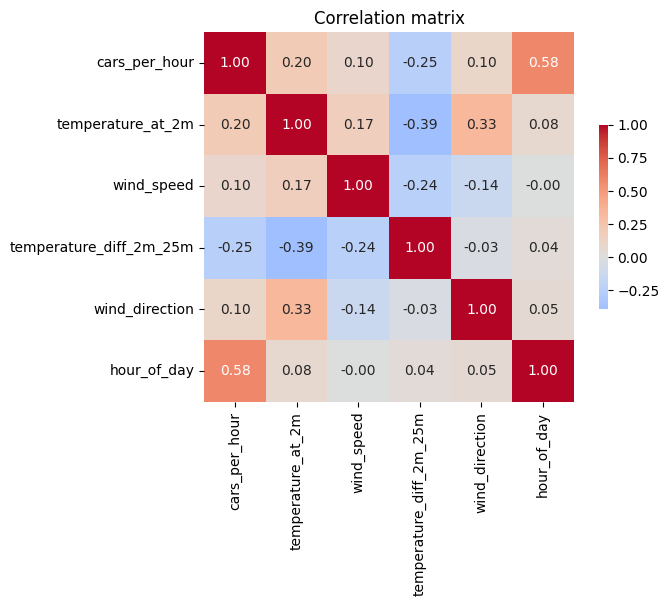

In [40]:
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True, cbar_kws={"shrink": .5})

plt.title('Correlation matrix')
plt.show()

- From the above correlation matrix plot, we notice that `hour_of_day` is strongly and positively correlated to `car_per_hour` with a correlation coefficient of `0.58`.

- Also we notice a weak and negative correlation between temperature variables: `temperature_at_2m`, and `temperature_diff_2m_25m`

## Exercise 1: Model benchmark
It is clear that $NO_2$ concentrations depend on a combination of these features, so we will now try to learn this complex relationship. We first evaluate a range of linear regression problems, i.e. Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN. Since we observed that some features have very different scales, we'll also build pipelines of all these measures with an additional scaling step. For now, we'll stick to the default hyperparameter settings.

### Exercise 1.1
Implement a function below which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You are allowed to import additional functions from whichever module you like, but you should be able to complete the function with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. Below you the function you will find example output.

In [41]:
def evaluate_learners(models, X, y):
    """
    Given a list of models [model1, model2, ..., modelN] return two lists:
     - a list with the scores obtained on the training samples for each model,
     - a list with the test scores obtained on the test samples for each model.
     The order of scores should match the order in which the models were originally provided. E.g.:
     [Model1 train score, ..., ModelN train score], [Model1 test score, ..., ModelN test score]
    """
    train_scores = []
    test_scores = []
    
    for model in models:
        scores = cross_validate(model, X, y, cv=5,
                         scoring=('r2', 'neg_mean_squared_error', ),
                         return_train_score=True)
        train_scores.append(scores["train_r2"])
        test_scores.append(scores["test_r2"])
    return train_scores, test_scores

# # Example output:
# train_scores, test_scores = ([[0.92 , 0.924, 0.916, 0.917, 0.921],  # Model 1 train score for each of 5 folds.
#                               [0.963, 0.962, 0.953, 0.912, 0.934],  # Model 2 train score for each of 5 folds.
#                               ..
#                              [[0.801, 0.811, 0.806, 0.826, 0.804],  # Model 1 test score for each of 5 folds.
#                               [0.766, 0.756, 0.773, 0.756, 0.741],  # Model 2 test score for each of 5 folds.
#                               ..

### Exercise 1.2
Call the function you created with a Linear Regression, Ridge, Lasso and ElasticNet, as well as kNN.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

In [42]:
# Dummy code. Replace with the actual classifiers and scores
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), KNeighborsRegressor()]
train_scores, test_scores = evaluate_learners(models, X, y)#[[0.6,0.7,0.8]], [[0.5,0.6,0.7]]

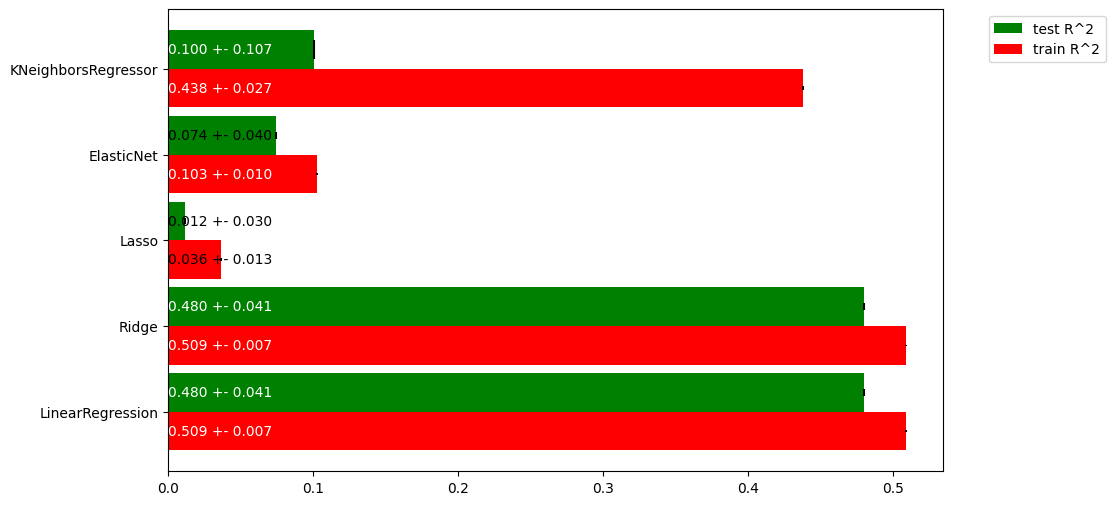

In [43]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots(figsize=(10,6))
width=0.45

ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test R^2')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train R^2')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.3f} +- {:.3f}".format(np.mean(te),np.std(te)), color=('white' if np.mean(te)>0.1 else 'black'), va='center')
    ax.text(0, i-width, "{:.3f} +- {:.3f}".format(np.mean(tr),np.std(tr)), color=('white' if np.mean(tr)>0.1 else 'black'), va='center')
labels = [c.__class__.__name__ if not hasattr(c, 'steps') else c.steps[0][0] + "_" + c.steps[1][0] for c in models]
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3
Interpret the plot. Which is the best regressor? Are any of the models overfitting? If so, what can we do to solve this? Is there a lot of variance in the results?

In [44]:
X.columns

Index(['cars_per_hour', 'temperature_at_2m', 'wind_speed',
       'temperature_diff_2m_25m', 'wind_direction', 'hour_of_day'],
      dtype='object')

- The best models are the `LinearRegression` and `Ridge` with a `R2 Score` of around 0.48. That means that the number of cars per hour, the temperature at 2 meters height, the wind speed, the temperature difference between 2 meters ans 25 meters, the wind direction and the hour of the day help to explain around **48%** of the variance existing in $NO_{2}$ level concentration due to cars.

- The `KNeighborsRegressor` is overfitting. We can do some regularization, get more data, or tune the hyperparameters of the model.
- Yes, there are a lot of variance of the result of the KNN
- `Lasso` and `ElasticNet` models are underfitting. To fix it, we can train the models longer or do somme feature engineering

## Exercise 2: Regularization
We will now tune these algorithm's main regularization hyperparameter: the regularization hyperparameter (`alpha`) in Lasso and Ridge, and the number of neighbors (`n_neighbors`) in kNN.

We expect the optimum for the alpha parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. alpha should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]), n_neighbors should be varied uniformly (i.e. [1,2,3,4]).

### Exercise 2.1
Vary the hyperparameters in the range given above and, for each regressor, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each regressor. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.

In [45]:
lasso_grid = GridSearchCV(Lasso(), param_grid={'alpha':np.geomspace(1e-12, 1e12, 1000)}, cv=5, scoring='r2',
                          return_train_score=True, n_jobs=-1, verbose=5, 
                        #   n_iter=100
                          )

ridge_grid = GridSearchCV(Ridge(), param_grid={'alpha':np.geomspace(1e-12, 1e12, 1000)}, cv=5, scoring='r2',
                            return_train_score=True, n_jobs=-1, verbose=5, 
                            # n_iter=100
                            )

knn_grid = GridSearchCV(KNeighborsRegressor(), param_grid={'n_neighbors':np.arange(1,51)}, cv=5, scoring='r2',
                            return_train_score=True, n_jobs=-1, verbose=5, 
                            # n_iter=100
                            )

In [46]:
lasso_cv_res = lasso_grid.fit(X, y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [47]:
lasso_cv_res.best_params_

{'alpha': 0.0014228304572143548}

In [48]:
ridge_cv_res = ridge_grid.fit(X, y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [49]:
ridge_cv_res.best_params_

{'alpha': 3.8778284145894615}

In [50]:
knn_cv_res = knn_grid.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [51]:
knn_cv_res.best_params_

{'n_neighbors': 12}

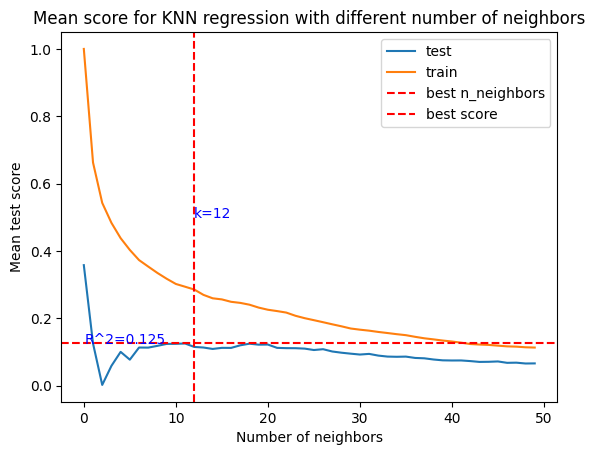

In [64]:
plt.plot(np.abs(knn_cv_res.cv_results_['mean_test_score']), label='test')
plt.plot(np.abs(knn_cv_res.cv_results_['mean_train_score']), label='train')

# add vertical line for best n_neighbors
plt.axvline(x=knn_cv_res.best_params_['n_neighbors'], color='r', linestyle='--', label='best n_neighbors')

# add knn value
plt.text(knn_cv_res.best_params_['n_neighbors'], 0.5, "k=" +str(knn_cv_res.best_params_['n_neighbors']), color='b')

# add horizontal line for best score
plt.axhline(y=knn_cv_res.best_score_, color='r', linestyle='--', label='best score')

plt.text(knn_cv_res.best_score_, knn_cv_res.best_score_, "R^2={:.3f}".format(knn_cv_res.best_score_), color='b' )


plt.title('Mean score for KNN regression with different number of neighbors')
plt.xlabel('Number of neighbors')
plt.ylabel('Mean test score')
plt.legend()
plt.show()

- The optimal model has **k=12** with a $R^2$ of around **0.12**: this model is underfitting.

- KNN tends to overfit for low value of `n_neighbors`, and to underfit for high ones

In [53]:
lasso_cv_res_df = pd.DataFrame(lasso_cv_res.cv_results_)

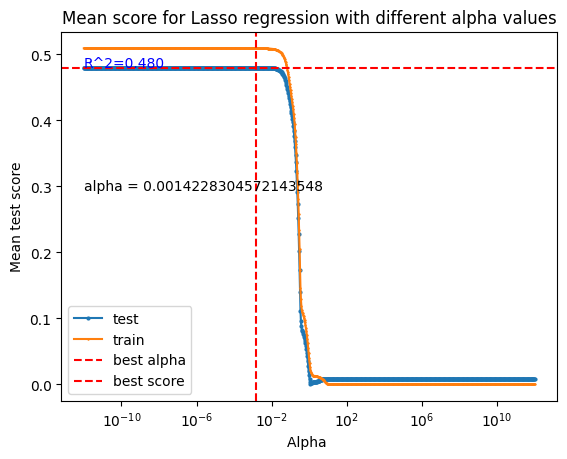

In [65]:
best_alpha_index = np.argmax(np.abs(lasso_cv_res.cv_results_['mean_test_score']))
best_train_score = lasso_cv_res.cv_results_['mean_train_score'][best_alpha_index]
best_test_score = lasso_cv_res.cv_results_['mean_test_score'][best_alpha_index]

best_alpha_label_pos = (best_train_score + best_test_score) / 2
radius = 1e12

indices = [i for i, x in enumerate(np.array(lasso_cv_res.cv_results_["param_alpha"])) if x- np.array(lasso_cv_res.cv_results_["param_alpha"])[best_alpha_index] < radius]

plt.plot(np.array(lasso_cv_res_df["param_alpha"][indices]), 
         np.abs(lasso_cv_res_df['mean_test_score'][indices]), 'o-', label='test', markersize=2)

plt.plot(np.array(lasso_cv_res.cv_results_["param_alpha"][indices]),
         np.abs(lasso_cv_res_df['mean_train_score'][indices]), '+-', label='train', markersize=2)

# add vertical line to mark the best alpha
plt.axvline(x=lasso_cv_res.best_params_['alpha'], color='r', linestyle='--', label='best alpha')

#write text to the write of the line indicating alpha value
plt.text(min(lasso_cv_res_df["param_alpha"]), best_alpha_label_pos-0.2, 
         'alpha = '+str(lasso_cv_res.best_params_['alpha']))

# add horizontal line for best score
plt.axhline(y=best_test_score, color='r', linestyle='--', label='best score')
plt.text(min(lasso_cv_res_df["param_alpha"]), best_test_score, "R^2={:.3f}".format(best_test_score), color='b')

plt.xscale("log")
plt.title('Mean score for Lasso regression with different alpha values')
plt.xlabel('Alpha ')
plt.ylabel('Mean test score')
plt.legend()
plt.show()

- The quality of the model prediction tends to decrease as the regularization parameter increases.
- The `Lasso` model is optimal for a low value of `alpha`, around **0.0014**, with a performance of around **0.48**: This model is just fitting

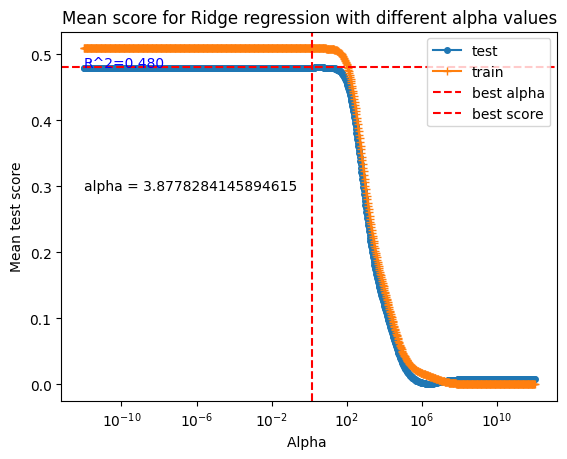

In [67]:
best_alpha_index = np.argmax(np.abs(ridge_cv_res.cv_results_['mean_test_score']))
best_train_score = np.abs(ridge_cv_res.cv_results_['mean_train_score'])[best_alpha_index]
best_test_score = np.abs(ridge_cv_res.cv_results_['mean_test_score'])[best_alpha_index]

best_alpha_label_pos = (best_train_score + best_test_score) / 2

radius = 1e12

indices = [i for i, x in enumerate(np.array(ridge_cv_res.cv_results_["param_alpha"])) if x- np.array(ridge_cv_res.cv_results_["param_alpha"])[best_alpha_index] < radius]

plt.plot(np.array(ridge_cv_res.cv_results_["param_alpha"])[indices], 
         np.abs(ridge_cv_res.cv_results_['mean_test_score'])[indices], 'o-', label='test', markersize=4)

plt.plot(np.array(ridge_cv_res.cv_results_["param_alpha"])[indices],
         np.abs(ridge_cv_res.cv_results_['mean_train_score'])[indices], '+-', label='train')

# add vertical line to mark the best alpha
plt.axvline(x=np.log(ridge_cv_res.best_params_['alpha']),  color='r', linestyle='--', label='best alpha', markersize=4)

#write text to the write of the line indicating alpha value
plt.text(min(ridge_cv_res.cv_results_["param_alpha"]), best_alpha_label_pos-0.2, 
         'alpha = '+str(ridge_cv_res.best_params_['alpha']))

# add horizontal line for best score
plt.axhline(y=best_test_score, color='r', linestyle='--', label='best score')
plt.text(min(ridge_cv_res.cv_results_["param_alpha"]), best_test_score, "R^2={:.3f}".format(best_test_score), color='b')

# set log scale on x axis
plt.xscale('log')
plt.title('Mean score for Ridge regression with different alpha values')
plt.xlabel('Alpha ')
plt.ylabel('Mean test score')
plt.legend(loc='upper right')
plt.show()

- Just like `Lasso`, `Ridge` the alpha value is negatively correlated to the model performance
- But unlike `Lasso`, `Ridge` model is more accurate for a high value of `alpha`, **around 3,9**

### Exercise 2.2
Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

![](of.jpeg)

- Regularization helps to solve overfitting. But too much regularization seems to lead to underfitting on this data.
- Lasso and Ridge are fitting to the data just right for the optimal value of alpha.

- KNN overfits for low values of `n_neighbors` and underfits for high ones.
- KNN model is underfitting, because we have high training error for the optimal value of k.

### Exercise 2.3
ElasticNet allows to mix L1 and L2 loss, and the `l1_ratio` hyperparameter defines the ratio of L1 loss. Hence, it has two interacting hyperparameters: l1_ratio and alpha. Run a grid search to obtain a matrix of l1_ratio and alpha values and the resulting cross-validation scores. Then, use the function provided below to plot a heatmap of all values and interpret the result. Can you explain how the two hyperparameters interact?

In [28]:
elasticnet_grid = GridSearchCV(ElasticNet(), param_grid={'alpha':np.geomspace(1e-12, 1e12, 100),
                                                         'l1_ratio':np.linspace(0,1,100)}, cv=5, scoring='r2',
                            return_train_score=True, n_jobs=-1, verbose=5)

elasticnet_cv_res = elasticnet_grid.fit(X, y)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


c:\Users\duamelo\.conda\envs\openml_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.984e+01, tolerance: 2.811e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


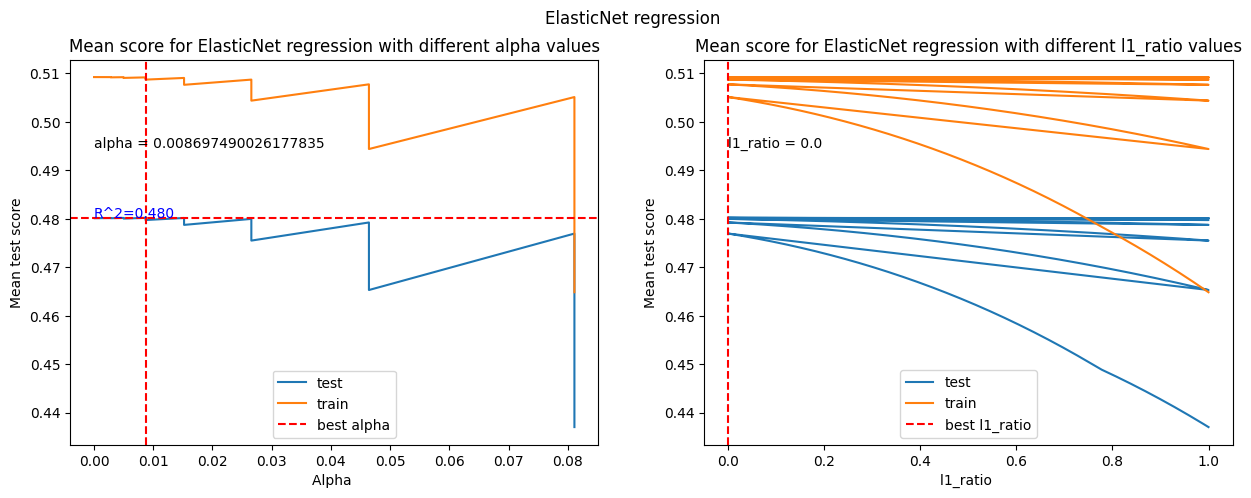

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

best_alpha_index = np.argmax(np.abs(elasticnet_cv_res.cv_results_['mean_test_score']))
best_train_score = np.abs(elasticnet_cv_res.cv_results_['mean_train_score'])[best_alpha_index]
best_test_score = np.abs(elasticnet_cv_res.cv_results_['mean_test_score'])[best_alpha_index]

best_alpha_label_pos = (best_train_score + best_test_score) / 2

radius = 0.1

indices = [i for i, x in enumerate(np.array(elasticnet_cv_res.cv_results_["param_alpha"])) if x- np.array(elasticnet_cv_res.cv_results_["param_alpha"])[best_alpha_index] < radius]

axs[0].plot(np.array(elasticnet_cv_res.cv_results_["param_alpha"])[indices],
            np.abs(elasticnet_cv_res.cv_results_['mean_test_score'])[indices], label='test')

axs[0].plot(np.array(elasticnet_cv_res.cv_results_["param_alpha"])[indices],
            np.abs(elasticnet_cv_res.cv_results_['mean_train_score'])[indices], label='train')

# add vertical line to mark the best alpha
axs[0].axvline(x=elasticnet_cv_res.best_params_['alpha'], color='r', linestyle='--', label='best alpha')

#write text to the write of the line indicating alpha value
axs[0].text(0, best_alpha_label_pos, 
            'alpha = '+str(elasticnet_cv_res.best_params_['alpha']))

axs[0].set_title('Mean score for ElasticNet regression with different alpha values')
axs[0].set_xlabel('Alpha ')
axs[0].set_ylabel('Mean test score')
axs[0].legend()

# add horizontal line for best score
axs[0].axhline(y=best_test_score, color='r', linestyle='--', label='best score')
axs[0].text(0, best_test_score, "R^2={:.3f}".format(best_test_score), color='b')

best_l1_ratio_index = np.argmax(np.abs(elasticnet_cv_res.cv_results_['mean_test_score']))

best_train_score_l1 = np.abs(elasticnet_cv_res.cv_results_['mean_train_score'])[best_l1_ratio_index]
best_test_score_l1 = np.abs(elasticnet_cv_res.cv_results_['mean_test_score'])[best_l1_ratio_index]

best_l1_ratio_label_pos = (best_train_score_l1 + best_test_score_l1) / 2

radius = 1

indices2 = [i for i, x in enumerate(np.array(elasticnet_cv_res.cv_results_["param_l1_ratio"])) if x- np.array(elasticnet_cv_res.cv_results_["param_l1_ratio"])[best_l1_ratio_index] < radius]

# l1_ratios = []
# indices = []
# for i in indices:
#     if elasticnet_cv_res.cv_results_["param_l1_ratio"][i] not in l1_ratios:
#         l1_ratios.append(elasticnet_cv_res.cv_results_["param_l1_ratio"][i])
#         indices.append(i)

axs[1].plot(np.array(elasticnet_cv_res.cv_results_["param_l1_ratio"])[indices],
            np.abs(elasticnet_cv_res.cv_results_['mean_test_score'])[indices], label='test')

axs[1].plot(np.array(elasticnet_cv_res.cv_results_["param_l1_ratio"])[indices],
            np.abs(elasticnet_cv_res.cv_results_['mean_train_score'])[indices], label='train')

# add vertical line to mark the best l1_ratio
axs[1].axvline(x=elasticnet_cv_res.best_params_['l1_ratio'], color='r', linestyle='--', label='best l1_ratio')

#write text to the write of the line indicating l1_ratio value
axs[1].text(0, best_l1_ratio_label_pos, 
            'l1_ratio = '+str(elasticnet_cv_res.best_params_['l1_ratio']))

axs[1].set_title('Mean score for ElasticNet regression with different l1_ratio values')

axs[1].set_xlabel('l1_ratio ')

axs[1].set_ylabel('Mean test score')

axs[1].legend()

plt.suptitle('ElasticNet regression')

plt.show()


In [30]:
# Generic heatmap
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=False):
    """
    Plots a heatmap for the performance of a model for every combination of two hyperparameter values

    values: nxn array with all evaluation results, varying the first hyperparameter first
    xlabel: name of the first hyperparameter
    ylabel: name of the second hyperparameter
    xticklabels: values of the first hyperparameter
    yticklabels: values of the second hyperparameter
    cmap: colormap
    vmin: minimal score
    vmax: maximal score
    ax: plot axes
    fmt: format for printing the scores
    printvalues: whether to print the scores
    """
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)

    if(printvalues):
        for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.mean(color[:3]) > 0.5:
                c = 'k'
            else:
                c = 'w'
            ax.text(x, y, fmt % value, color=c, ha="center", va="center", size=10)
    return img

In [25]:
res=pd.DataFrame(elasticnet_cv_res.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.024961,0.007675,0.000000,0.000000,0.0,0.0,"{'alpha': 1e-12, 'l1_ratio': 0.0}",0.453936,0.512294,0.413691,...,0.480097,0.041175,4093,0.515866,0.50342,0.518716,0.507242,0.50085,0.509219,0.006956
1,0.003125,0.006250,0.006250,0.007654,0.0,0.010101,"{'alpha': 1e-12, 'l1_ratio': 0.010101010101010...",0.453936,0.512294,0.413691,...,0.480097,0.041175,4094,0.515866,0.50342,0.518716,0.507242,0.50085,0.509219,0.006956
2,0.024999,0.018750,0.021875,0.036445,0.0,0.020202,"{'alpha': 1e-12, 'l1_ratio': 0.020202020202020...",0.453936,0.512294,0.413691,...,0.480097,0.041175,4091,0.515866,0.50342,0.518716,0.507242,0.50085,0.509219,0.006956
3,0.018729,0.006261,0.003129,0.006258,0.0,0.030303,"{'alpha': 1e-12, 'l1_ratio': 0.030303030303030...",0.453936,0.512294,0.413691,...,0.480097,0.041175,4091,0.515866,0.50342,0.518716,0.507242,0.50085,0.509219,0.006956
4,0.009482,0.007744,0.031321,0.032885,0.0,0.040404,"{'alpha': 1e-12, 'l1_ratio': 0.04040404040404041}",0.453936,0.512294,0.413691,...,0.480097,0.041175,4086,0.515866,0.50342,0.518716,0.507242,0.50085,0.509219,0.006956


In [27]:
res2 = res.pivot_table(index='param_alpha', columns='param_l1_ratio', values='mean_test_score')

In [28]:
res2.shape

(100, 100)

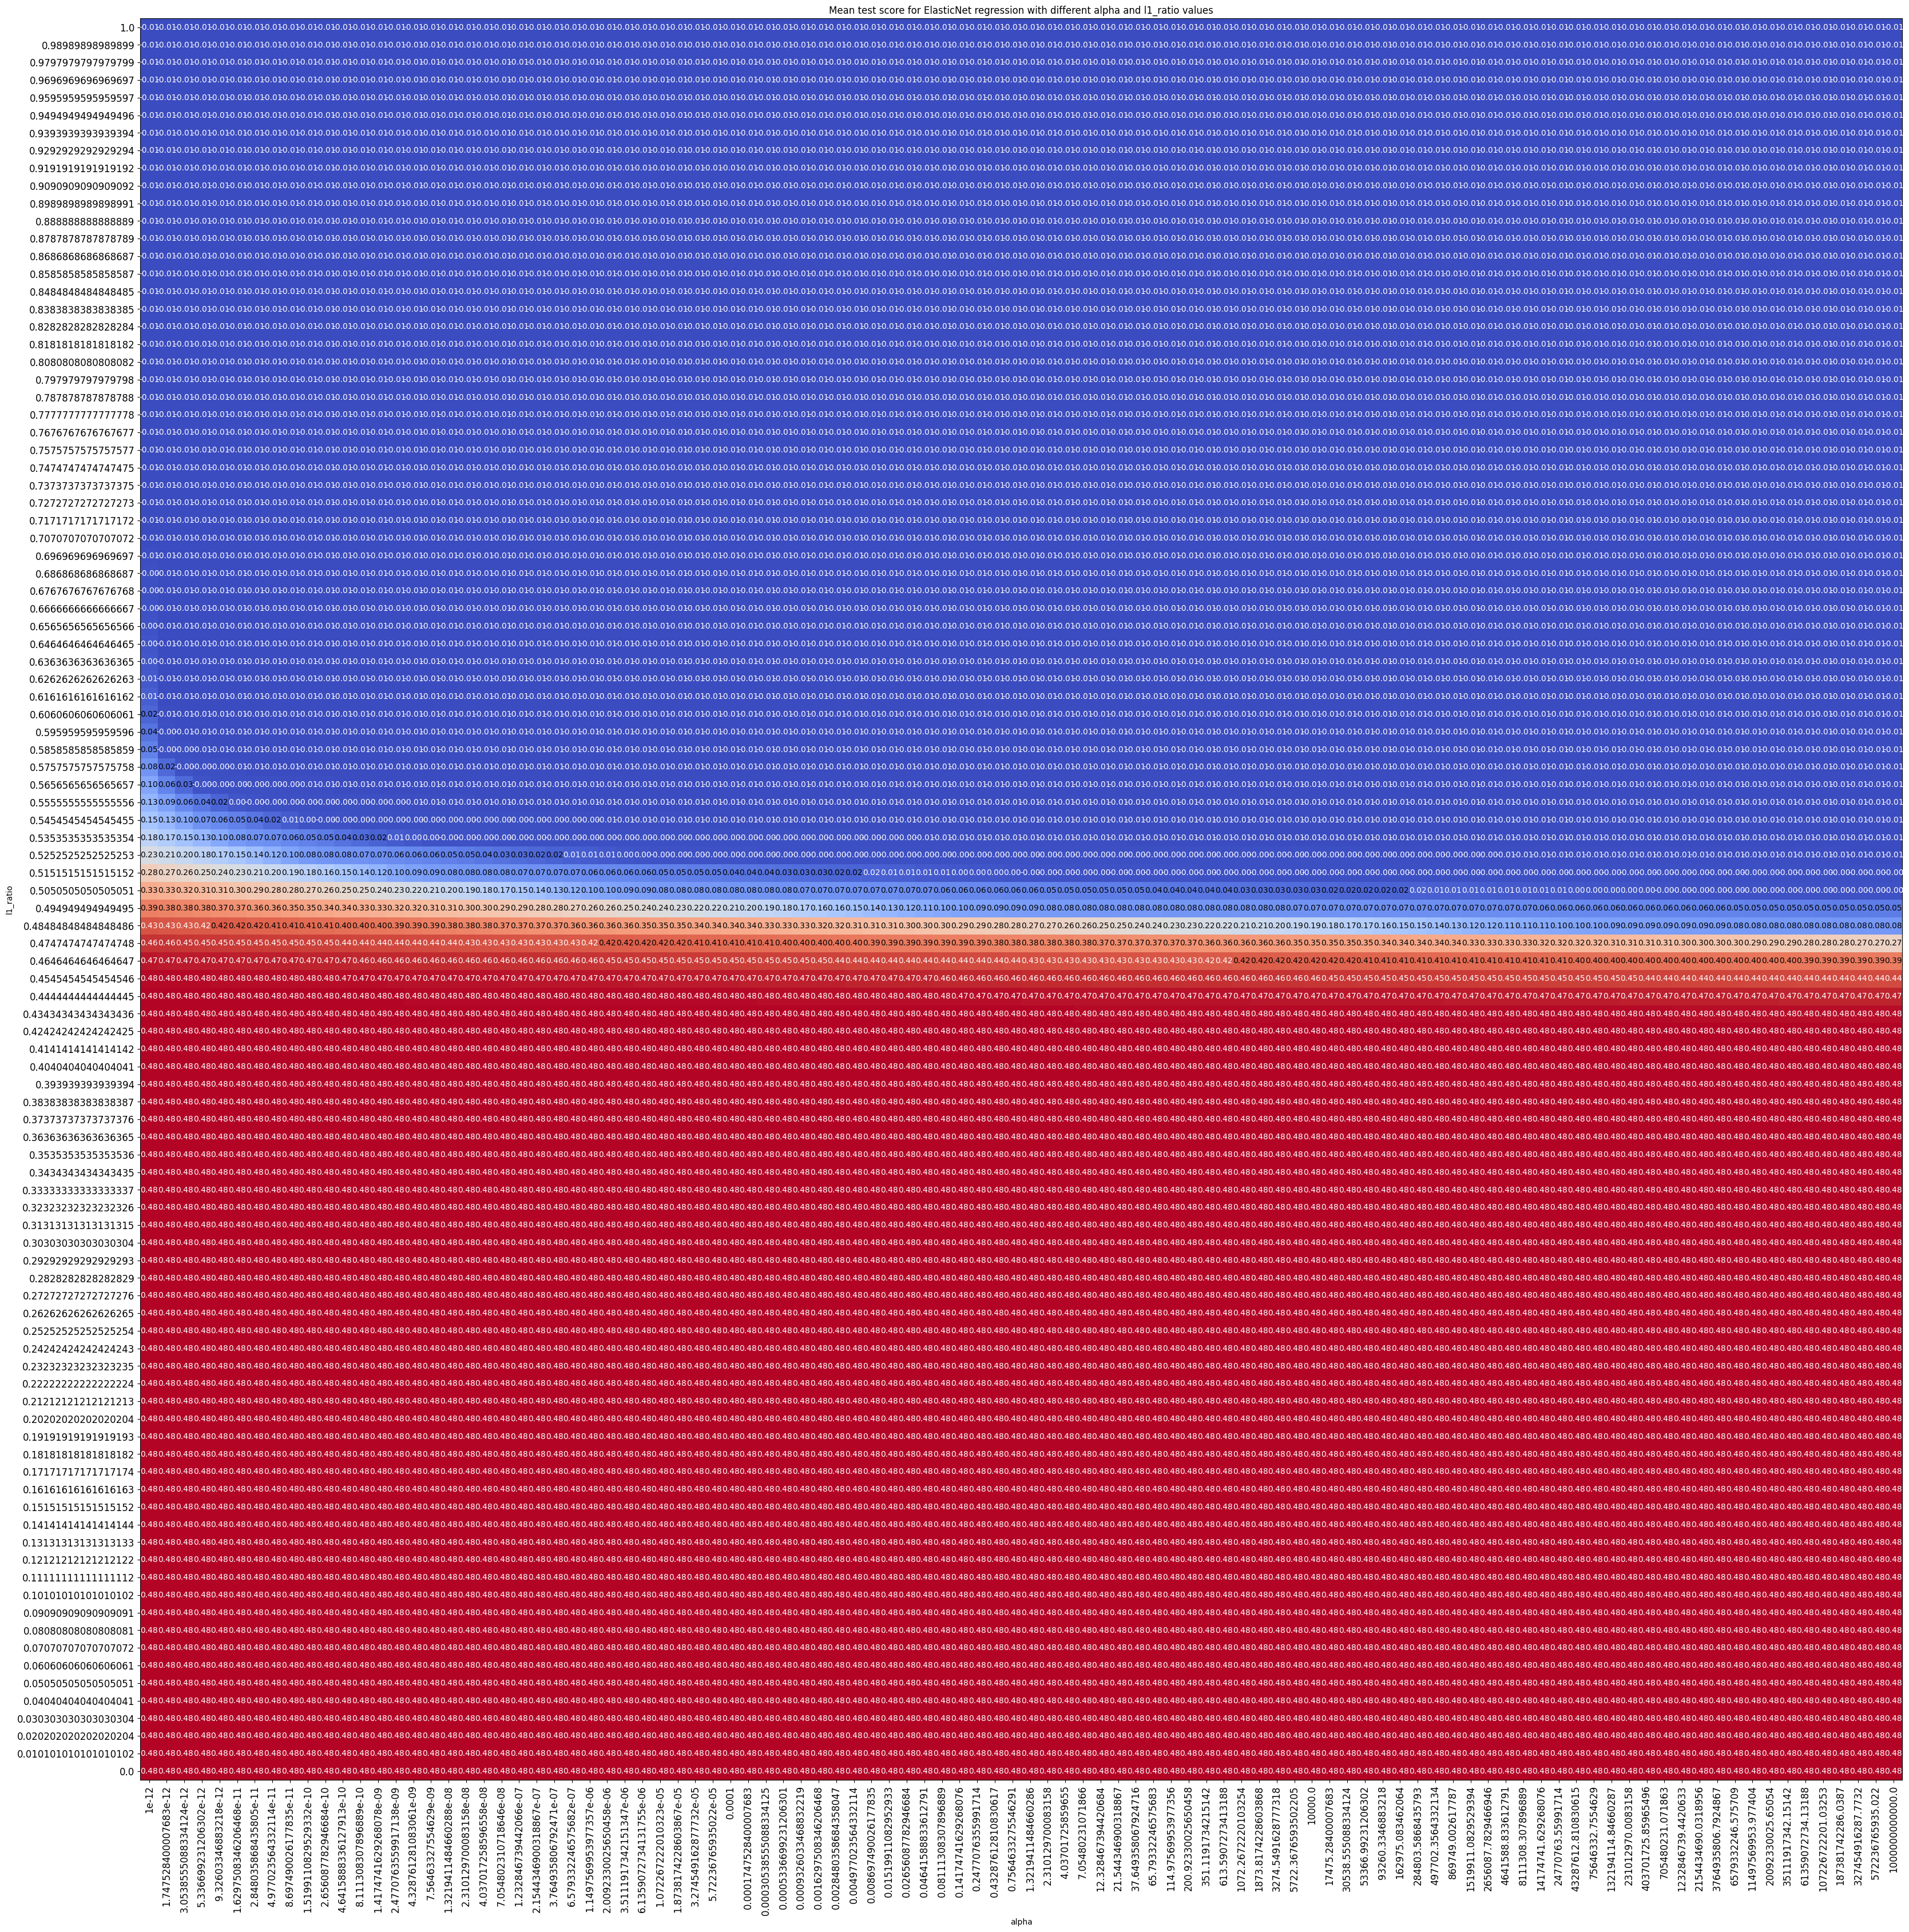

In [75]:
plt.figure(figsize=(40, 40))

heatmap(res2.values, "alpha", "l1_ratio", res2.index.tolist(),
        res2.columns.tolist(), cmap="coolwarm", vmin=None, vmax=None, ax=None, fmt="%0.2f", printvalues=True)

plt.title('Mean test score for ElasticNet regression with different alpha and l1_ratio values')

plt.show()

- The above heatmap shows the model performance on test set by varying the alpha and l1_ratio hyperparameters of the `ElasticNet` models.
- We notice that the model isn't really sensitive to the value of alpha but l1_ratio really affects the performace of the model: We see that for `l1_ration<0.44`, we have the best performance in red on the plot of around 0.48 no matter the value of `alpha`, whereas for value above this treshold, the model's performance degrades.

## Exercise 3: Visualizing coefficients
Finally, let's verify whether the different optimized linear models also find the same coefficients.

### Exercise 3.1
Draw a [scatterplot](https://matplotlib.org/gallery/shapes_and_collections/scatter.html) plotting the coefficients of the different models in different colors. Do you see much difference between the different models?

For all models, choose an alpha parameter that seems to work well in the previous exercise. When in doubt, use alpha=0.001.

In [30]:
lin_reg_grid = GridSearchCV(LinearRegression(), param_grid={'fit_intercept':[True, False], 'positive':[True, False],
                                                            }, cv=5, scoring='neg_mean_squared_error',
                            return_train_score=True, n_jobs=-1, verbose=5)

lin_reg_cv_res = lin_reg_grid.fit(X, y)

lin_reg_cv_res.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


{'fit_intercept': True, 'positive': False}

In [31]:
lasso_cv_res.best_estimator_

Lasso(alpha=0.0014228304572143548)

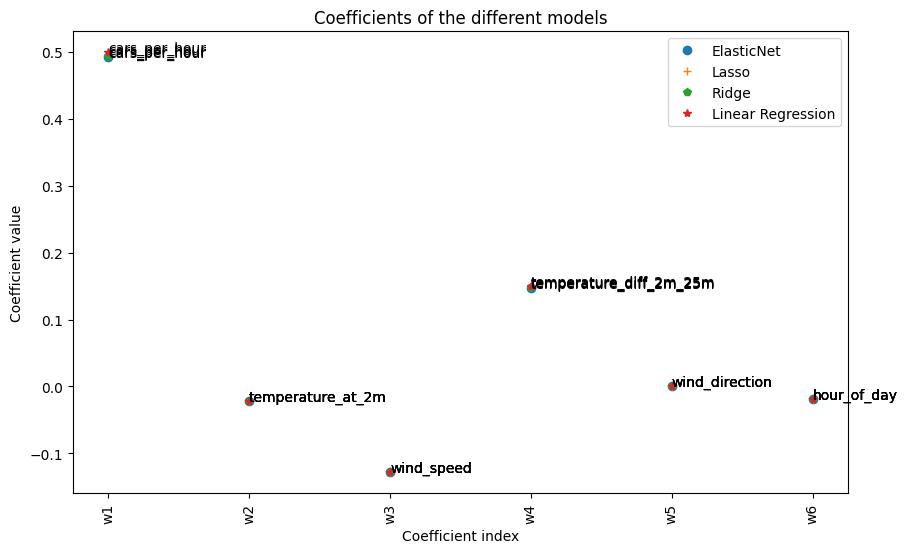

In [53]:
# scatterplot of models coefficients
plt.figure(figsize=(10, 6))

plt.plot(np.arange(len(elasticnet_cv_res.best_estimator_.coef_)), elasticnet_cv_res.best_estimator_.coef_, 'o', label='ElasticNet')
plt.plot(np.arange(len(lasso_cv_res.best_estimator_.coef_)), lasso_cv_res.best_estimator_.coef_, '+', label='Lasso')
plt.plot(np.arange(len(ridge_cv_res.best_estimator_.coef_)), ridge_cv_res.best_estimator_.coef_, 'p', label='Ridge')   
plt.plot(np.arange(len(lin_reg_cv_res.best_estimator_.coef_)), lin_reg_cv_res.best_estimator_.coef_, '*', label='Linear Regression')

## show that points are overlapping
for i in range(len(lin_reg_cv_res.best_estimator_.coef_)):
    plt.text(i, lin_reg_cv_res.best_estimator_.coef_[i], attribute_names[i])
    plt.text(i, elasticnet_cv_res.best_estimator_.coef_[i], attribute_names[i])
    plt.text(i, lasso_cv_res.best_estimator_.coef_[i], attribute_names[i])
    plt.text(i, ridge_cv_res.best_estimator_.coef_[i], attribute_names[i])

plt.title('Coefficients of the different models')
plt.xticks(np.arange(len(attribute_names[:-1])), [f"w{i}" for i in range(1, 7)], rotation=90)
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.legend()
plt.show()

- From the above plot, we don't see much difference between the different plots.

In [62]:
coeffs = pd.DataFrame({'attribute': attribute_names[:-1],
                          'lin_reg': lin_reg_cv_res.best_estimator_.coef_,
                          'lasso': lasso_cv_res.best_estimator_.coef_,
                          'ridge': ridge_cv_res.best_estimator_.coef_,
                          'elasticnet': elasticnet_cv_res.best_estimator_.coef_})
    
# add R2 scores to dataframe
coeffs = pd.concat([coeffs,
                   pd.DataFrame({'attribute': ["Performance"],
                                'lin_reg': [lin_reg_cv_res.best_score_],
                                'lasso': [lasso_cv_res.best_score_],
                                'ridge': [ridge_cv_res.best_score_], 
                                'elasticnet': [elasticnet_cv_res.best_score_]})], axis=0)

In [63]:
coeffs

,attribute,lin_reg,lasso,ridge,elasticnet
0,cars_per_hour,0.499486,0.496660,0.493486,0.492768
1,temperature_at_2m,-0.022037,-0.022099,-0.022094,-0.022101
2,wind_speed,-0.128685,-0.128295,-0.128313,-0.128267
3,temperature_diff_2m_25m,0.150790,0.148759,0.148142,0.147826
4,wind_direction,0.000674,0.000678,0.000681,0.000682
5,hour_of_day,-0.018703,-0.018397,-0.018131,-0.018062
0,Performance,-0.287250,0.480112,0.480173,0.480172


- From the above table, we see slight differences in regression coefficients of the different models
- Despite having almost the same weights, the models performance are different: Penalized models with the best score don't differ much between themselves, but much from linear regression, which fits the worst to the data.

### Exercise 3.2
Redraw the same plot but now using a large amount of regularization (e.g. alpha=1). What do you observe? Does this help you explain the performance difference between Ridge and Lasso in exercise 1.2?

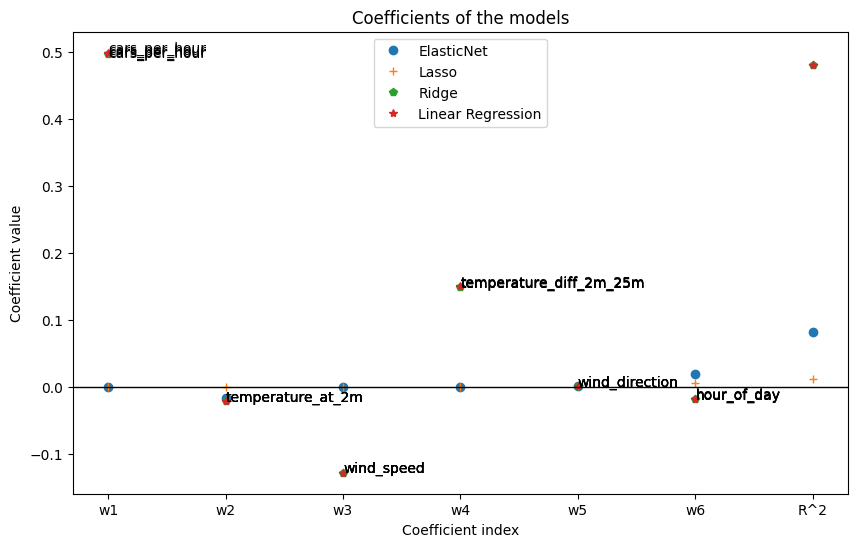

In [79]:
models = [LinearRegression(fit_intercept=True, positive=False), Ridge(alpha=1), Lasso(alpha=1), ElasticNet(alpha = 1, l1_ratio=0.4)]

coeffs = {}
for model in models:
    coeffs[type(model).__name__] = list(np.mean(np.array([cross_validate(model, X, y, cv=5, return_estimator=True)['estimator'][i].coef_ for i in range(5)]), axis=0))\
                                 + list([np.mean(cross_validate(model, X, y, cv=5, scoring='r2')['test_score'])])

plt.figure(figsize=(10, 6))

plt.plot(np.arange(len(coeffs['ElasticNet'])), coeffs['ElasticNet'], 'o', label='ElasticNet')
plt.plot(np.arange(len(coeffs['Lasso'])), coeffs['Lasso'], '+', label='Lasso')
plt.plot(np.arange(len(coeffs['Ridge'])), coeffs['Ridge'], 'p', label='Ridge')
plt.plot(np.arange(len(coeffs['LinearRegression'])), coeffs['LinearRegression'], '*', label='Linear Regression')

## show that points are overlapping
for i in range(len(lin_reg_cv_res.best_estimator_.coef_)):
    plt.text(i, lin_reg_cv_res.best_estimator_.coef_[i], attribute_names[i])
    plt.text(i, elasticnet_cv_res.best_estimator_.coef_[i], attribute_names[i])
    plt.text(i, lasso_cv_res.best_estimator_.coef_[i], attribute_names[i])
    plt.text(i, ridge_cv_res.best_estimator_.coef_[i], attribute_names[i])
    
plt.xticks(np.arange(7), [f"w{i}" for i in range(1, 7)] + ['R^2'])
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')

# add horizontalline at zero
plt.axhline(0, color='black', lw=1)

# legend to center right
plt.legend(loc='upper center')
plt.title('Coefficients of the models')
plt.show()

- From the above plot, we notice that the coefficients aren't aligned anymore: `Ridge` and `Lasso` don't regularize the weights associated to variables the same way: 

    + `Lasso` makes the coefficient associated to all the variables equal to zero
    + `Ridge` only makes the coefficient associated to `wind_speed` equals to zero

- This could explain the difference in performance between `Ridge` and `Lasso` in **1.2**: **Lasso** to use almost no features in the prediction, which explain the poor performance. 

    + For high values of `alpha`, **Lasso** tends to make the weight of all variables equal to zero and leads model poor quality.

In [34]:
coeffs.update({'Features': X.columns.tolist() + ['R^2']})

In [35]:
pd.DataFrame(coeffs).set_index('Features')

,LinearRegression,Ridge,Lasso,ElasticNet
Features,,,,
cars_per_hour,0.499188,0.497236,0.000000,0.000000
temperature_at_2m,-0.022075,-0.022094,-0.000780,-0.013989
wind_speed,-0.128710,-0.128589,0.000000,0.000000
temperature_diff_2m_25m,0.150536,0.149672,0.000000,0.000000
wind_direction,0.000682,0.000684,0.000851,0.001198
hour_of_day,-0.018654,-0.018467,0.004979,0.016400
R^2,0.480097,0.480132,0.011522,0.074157
